In [1]:
from pedigree_functions import *
import matplotlib.pyplot as plt
import scipy.stats as stats

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [79]:
cross_selfing_ped(5)

,id,parent0,parent1,time
0,0,.,.,6
1,1,.,.,6
2,2,0,1,5
3,3,0,1,5
4,4,0,1,5
5,5,0,1,5
6,6,0,1,5
7,7,2,2,4
8,8,3,3,4
9,9,4,4,4


In [2]:
#read genetic map
genmap = pd.read_csv("data/test_data/B73_genmap.csv")
#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")
#read reference allele
ref_allele = pd.read_csv("data/test_data/B73_alleles.csv")

In [115]:
#constant recombination rate test
#heterozygotes after one geno test
#sim ancestry after selective mating cross 5 offspring, propagate geno: full heterozygotes?
het = pedigree_init(2)
het = add_selective_mating(het, list([0,1]), 5)
het_ts = df_to_ts(het, seq_len = 100)
het_arg = msprime.sim_ancestry(initial_state = het_ts, model = "fixed_pedigree", recombination_rate = 0.01)
#why only outlier/bias to 0/reference
#test with tskit api calls (trees/node queries: parents, is_descendant, _mrca)
#mean recomb tract length

In [116]:
print(het_arg.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤════════════════╗
║id│flags│location│parents│metadata        ║
╠══╪═════╪════════╪═══════╪════════════════╣
║0 │    0│        │ -1, -1│{'file_id': '0'}║
║1 │    0│        │ -1, -1│{'file_id': '1'}║
║2 │    0│        │   0, 1│{'file_id': '2'}║
║3 │    0│        │   0, 1│{'file_id': '3'}║
║4 │    0│        │   0, 1│{'file_id': '4'}║
║5 │    0│        │   0, 1│{'file_id': '5'}║
║6 │    0│        │   0, 1│{'file_id': '6'}║
╚══╧═════╧════════╧═══════╧════════════════╝

Nodes
╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    0│         0│         0│   1│        ║
║1 │    0│         0│         0│   1│        ║
║2 │    0│         0│         1│   1│        ║
║3 │    0│         0│         1│   1│        ║
║4 │    1│         0│         2│   0│        ║
║5 │    1│         0│         2

In [98]:
het_map = genmap.iloc[0:3]

In [100]:
het_map["Position(bp)"] = list([25,50,75])

C:\Users\PHLUP\AppData\Local\Temp\ipykernel_13116\2467304492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  het_map["Position(bp)"] = list([25,50,75])


In [ ]:
het_map["Rate(cM/Mb)"] = list([0,0,0])

In [ ]:
het_map["Map(cM)"] = list([0,0,0])

In [110]:
het_founders = get_founder_nodes(parent_genos, list(["B73", "B97"]))

In [117]:
het_geno = propagate_geno(het_arg, het_founders, het_map)

In [118]:
het_geno

,node,PZA01271.1,PZA03613.1,PZA02129.1
0,0,C,A,T
1,1,C,A,T
2,2,G,T,C
3,3,G,T,C
4,4,C,A,T
5,5,G,T,C
6,6,C,A,T
7,7,G,T,C
8,8,C,A,T
9,9,G,T,C


In [119]:
join_nodes(het_arg, het_geno)

,individual,PZA01271.1,PZA03613.1,PZA02129.1
0,2,CG,AT,TC
1,3,CG,AT,TC
2,4,CG,AT,TC
3,5,CG,AT,TC
4,6,CG,AT,TC


In [3]:
whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "CML103"]), offspring = 194, selfing_genos = 5)

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10


In [80]:
genmap

,Marker,Chromosome,Position(bp),Rate(cM/Mb),Map(cM)
0,PZA01271.1,1,1947984,5.931497,0.0
1,PZA03613.1,1,2914171,8.536037,0.9
2,PZA02129.1,1,3706018,6.784706,3.7
3,PZA02032.1,1,4490461,9.290881,5.1
4,PHM2244.142,1,5562502,7.735375,9.7
...,...,...,...,...,...
969,PHM5435.25,10,144239494,8.220602,82.2
970,PZA01073.1,10,144549995,8.921778,83.2
971,PZA01001.2,10,146538889,18.267878,91.0
972,PZA02578.1,10,146553963,10.608550,91.2


In [68]:
#genmap with higher recomb rate
genmap["Rate(cM/Mb)"] += 5

In [70]:
high_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "CML103"]), offspring = 194, selfing_genos = 5)

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10


In [4]:
whole_sim

SNP,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM11985.27,PHM1218.6,PHM12706.14,PHM12749.13,PHM1275.22,...,kip1.3,lac1.3,sh2.21,umc128.2,umc13.1,vdac1a.1,wx1.1,zb21.1,zb27.1,zfl2.9
individual,,,,,,,,,,,,,,,,,,,,,
972,0,0,0,0,2,2,0,0,2,2,...,0,2,0,0,2,0,2,0,0,2
973,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
974,2,0,0,2,2,2,0,0,0,1,...,0,2,2,0,0,0,0,0,2,0
975,2,0,0,0,2,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,0
976,2,0,0,0,0,2,0,0,2,2,...,0,2,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2,0,0,0,0,2,0,0,0,2,...,0,2,0,0,2,0,2,0,0,2
1162,2,0,0,0,0,2,0,0,2,2,...,0,2,0,0,2,0,0,0,0,2
1163,0,0,0,2,2,2,0,0,2,2,...,0,2,2,0,0,0,0,0,0,0


In [5]:
pd.Series(whole_sim.values.flatten().tolist()).value_counts()

0    122809
2     61805
1      4342
Name: count, dtype: int64

In [71]:
pd.Series(high_sim.values.flatten().tolist()).value_counts()

0    122324
2     62588
1      4044
Name: count, dtype: int64

In [72]:
whole_sim.sum(axis = 1).mean()

659.5463917525773

In [73]:
high_sim.sum(axis = 1).mean()

666.0824742268042

In [74]:
whole_sim.sum(axis = 1).var()

17584.912344426048

In [75]:
high_sim.sum(axis = 1).var()

16277.671919235081

In [1]:
#get mean and sd + variance of simulation replicates
#mean = []
#var = []
#for i in range(0,10):
#    whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
#                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5)
#    mean.append(whole_sim.sum(axis = 1).mean())
#    var.append(whole_sim.sum(axis = 1).var())

In [8]:
np.mean(mean)

NameError: name 'mean' is not defined

In [56]:
np.std(mean)

9.311030149362745

In [60]:
np.mean(var)

16742.91505528551

In [58]:
np.std(var)

2087.783198123807

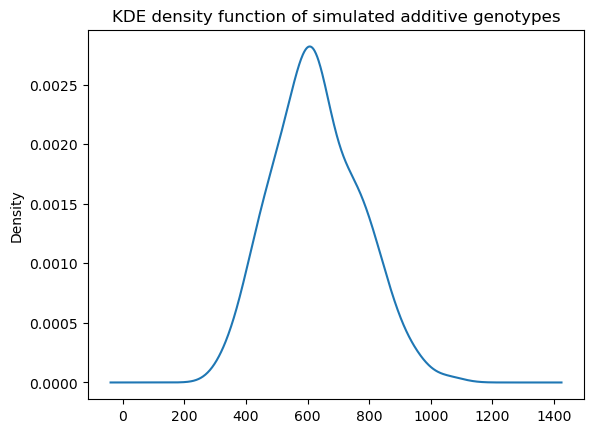

In [70]:
whole_sim.sum(axis = 1).plot.kde()
plt.title("KDE density function of simulated additive genotypes")
plt.savefig("plots/KDE_sim.png")

In [51]:
stats.kstest(whole_sim.sum(axis = 1), "norm")

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=289, statistic_sign=-1)

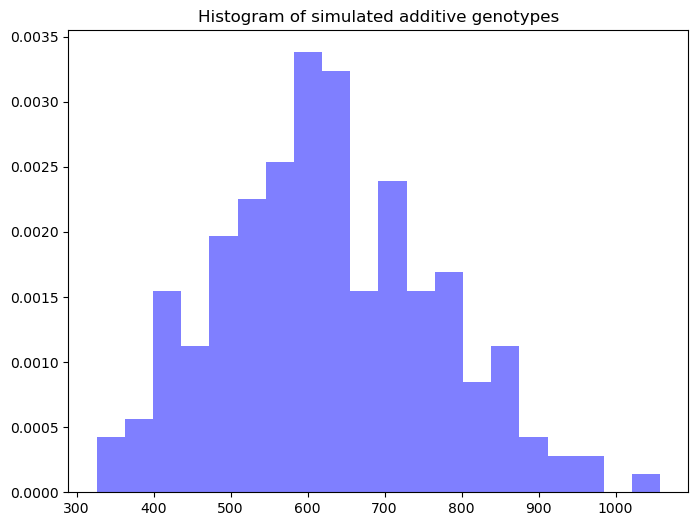

In [69]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(whole_sim.sum(axis = 1), bins = 20, density = True, alpha = 0.5, color = "b")
plt.title("Histogram of simulated additive genotypes")
plt.savefig("plots/Hist_sim.png")

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [10]:
#population one genotypes and allele frequencies
pop_1_genos = pd.read_csv("data/test_data/pop_2_genos.csv")
pop_1_genos = pop_1_genos[pop_1_genos.columns.intersection(genmap["Marker"])]

In [11]:
pop_1_genos

,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,...,PZA03607.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,2,2,2.0,2.0,1.5,1.0,1.0,1,1,1.5,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
1,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
2,0,0,0.0,0.0,0.0,1.0,1.0,1,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
3,0,0,0.0,0.0,0.0,2.0,2.0,2,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.5,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
192,2,2,2.0,2.0,0.0,0.0,0.0,0,0,0.0,...,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
193,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
194,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,1.0,1.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2


In [12]:
pop_1_genos.sum(axis = 1).mean()

1001.5204081632653

In [13]:
pop_1_genos.sum(axis = 1).var()

35802.91496598639

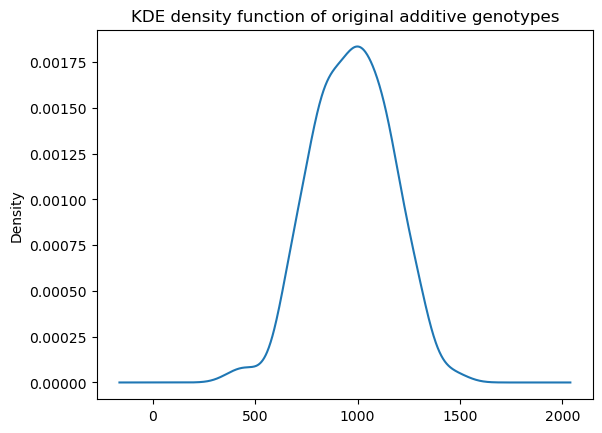

In [68]:
pop_1_genos.sum(axis = 1).plot.kde()
plt.title("KDE density function of original additive genotypes")
plt.savefig("plots/KDE_original.png")

In [37]:
stats.kstest(pop_1_genos.sum(axis = 1), "norm")

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=387.5, statistic_sign=-1)

In [38]:
pop_1_genos.sum(axis = 1).value_counts()

1101.0    3
1092.5    2
899.0     2
977.0     2
808.5     2
         ..
772.5     1
784.0     1
1276.5    1
978.0     1
626.5     1
Name: count, Length: 181, dtype: int64

In [39]:
pd.Series(pop_1_genos.values.flatten().tolist()).value_counts()

0.0    86689
2.0    86050
1.0    12850
0.5     1776
1.5     1591
Name: count, dtype: int64

In [76]:
12850 / pd.Series(pop_1_genos.values.flatten().tolist()).value_counts().sum()

0.06731131877802456

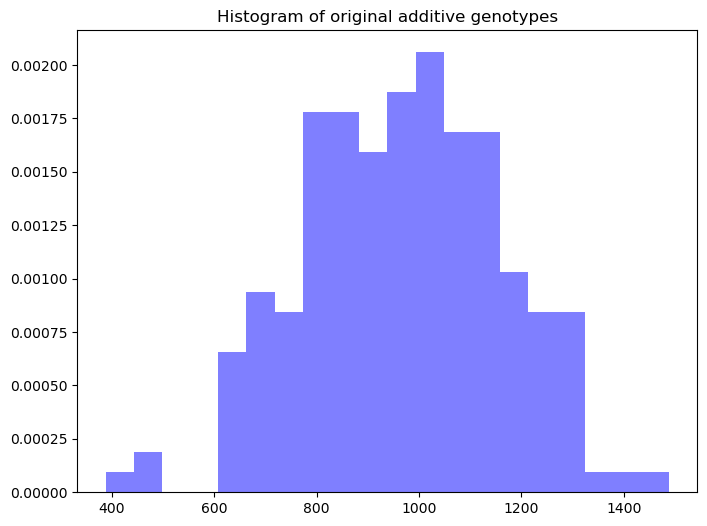

In [71]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(pop_1_genos.sum(axis = 1), bins = 20, density = True, alpha = 0.5, color = "b")
plt.title("Histogram of original additive genotypes")
plt.savefig("plots/Hist_original.png")

In [21]:
genmap

,Marker,Chromosome,Position(bp),Rate(cM/Mb),Map(cM)
0,PZA01271.1,1,1947984,0.931497,0.0
1,PZA03613.1,1,2914171,3.536037,0.9
2,PZA02129.1,1,3706018,1.784706,3.7
3,PZA02032.1,1,4490461,4.290881,5.1
4,PHM2244.142,1,5562502,2.735375,9.7
...,...,...,...,...,...
969,PHM5435.25,10,144239494,3.220602,82.2
970,PZA01073.1,10,144549995,3.921778,83.2
971,PZA01001.2,10,146538889,13.267878,91.0
972,PZA02578.1,10,146553963,5.608550,91.2


In [20]:
pop_1_genos[genmap["Marker"]]

,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,PZA00175.2,...,PZA03604.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,2,2,2.0,2.0,1.5,1.0,1.0,1,1,1.5,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
1,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
2,0,0,0.0,0.0,0.0,1.0,1.0,1,1,1.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
3,0,0,0.0,0.0,0.0,2.0,2.0,2,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.5,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
192,2,2,2.0,2.0,0.0,0.0,0.0,0,0,0.0,...,2.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
193,2,2,2.0,2.0,2.0,2.0,2.0,2,2,2.0,...,2.0,2.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2
194,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,1.0,2.0,2.0,2.0,2,2.0,2.0,2.0,2


In [25]:
whole_sim[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0)

SNP
PZA01271.1       0.000000
PZA03613.1       0.943299
PZA02129.1       0.943299
PZA02032.1       1.881443
PHM2244.142      2.798969
                  ...    
PHM5435.25     656.463918
PZA01073.1     657.438144
PZA01001.2     657.438144
PZA02578.1     658.474227
PZA00062.4     659.546392
Length: 974, dtype: float64

Text(0.5, 1.0, 'Mean of cumulative sum along the chromosome simulated')

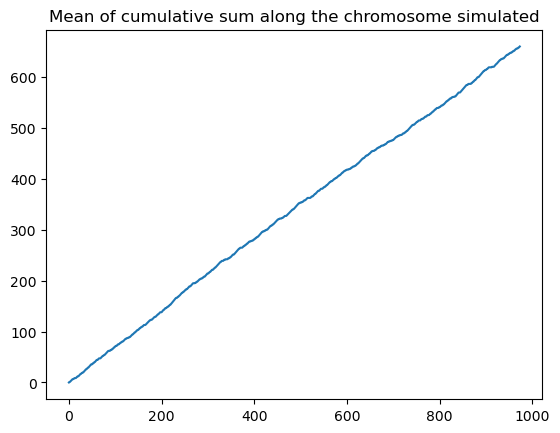

In [36]:
plt.plot(range(len(whole_sim[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))), whole_sim[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))
plt.title("Mean of cumulative sum along the chromosome simulated")

Text(0.5, 1.0, 'Mean along the chromosome simulated')

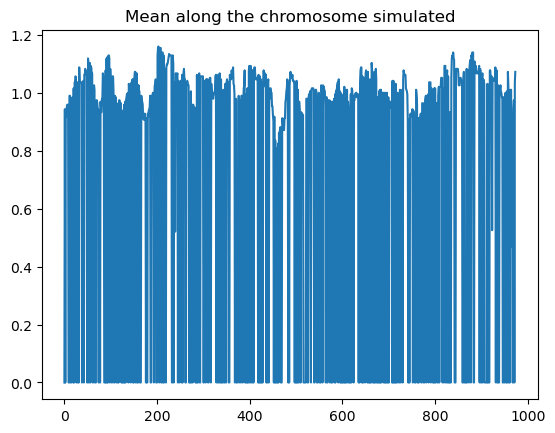

In [47]:
plt.plot(range(len(whole_sim[genmap["Marker"]].mean(axis = 0))), whole_sim[genmap["Marker"]].mean(axis = 0))
plt.title("Mean along the chromosome simulated")

In [49]:
whole_sim[genmap["Marker"]].mean(axis = 0)

SNP
PZA01271.1     0.000000
PZA03613.1     0.943299
PZA02129.1     0.000000
PZA02032.1     0.938144
PHM2244.142    0.917526
                 ...   
PHM5435.25     0.943299
PZA01073.1     0.974227
PZA01001.2     0.000000
PZA02578.1     1.036082
PZA00062.4     1.072165
Length: 974, dtype: float64

In [56]:
whole_sim[genmap["Marker"]].mean(axis = 0).max() - whole_sim[genmap["Marker"]].mean(axis = 0).min()

1.1597938144329898

In [ ]:
plt.plot(range(len(whole_sim[genmap["Marker"]].var(axis = 0))), whole_sim[genmap["Marker"]].var(axis = 0))
plt.title("Variance along the chromosome simulated")

Text(0.5, 1.0, 'Variance along the chromosome simulated')

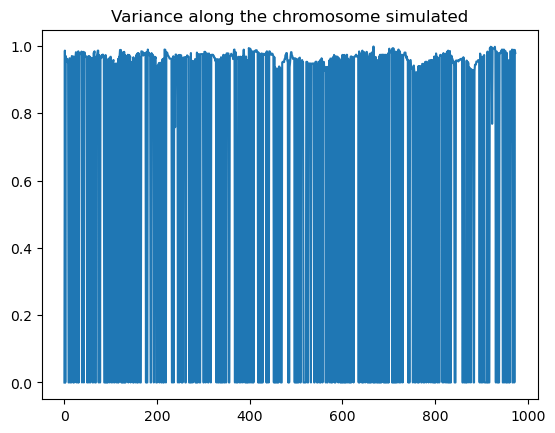

In [46]:
plt.plot(range(len(whole_sim[genmap["Marker"]].var(axis = 0))), whole_sim[genmap["Marker"]].var(axis = 0))
plt.title("Variance along the chromosome simulated")

Text(0.5, 1.0, 'Mean of cumulative sum along the chromosome original')

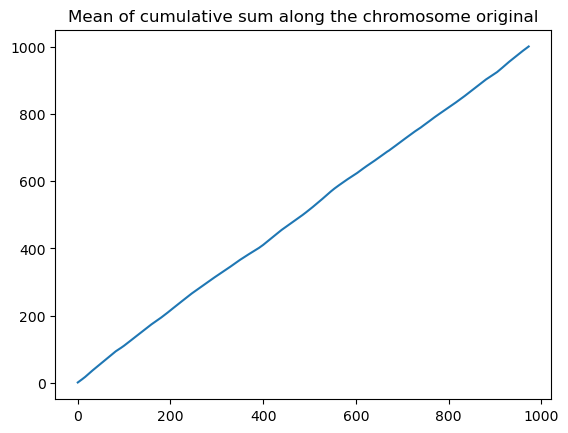

In [38]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))), pop_1_genos[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))
plt.title("Mean of cumulative sum along the chromosome original")

Text(0.5, 1.0, 'Variance of cumulative sum along the chromosome original')

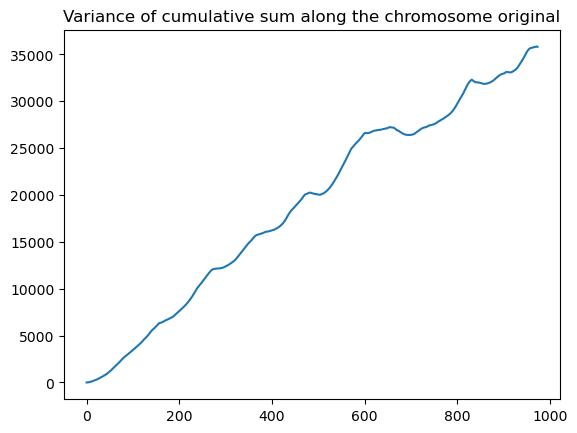

In [40]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].cumsum(axis = 1).var(axis = 0))), pop_1_genos[genmap["Marker"]].cumsum(axis = 1).var(axis = 0))
plt.title("Variance of cumulative sum along the chromosome original")

In [55]:
pop_1_genos[genmap["Marker"]].mean(axis = 0)

PZA01271.1     1.061224
PZA03613.1     1.061224
PZA02129.1     1.040816
PZA02032.1     1.022959
PHM2244.142    0.989796
                 ...   
PHM5435.25     1.030612
PZA01073.1     1.017857
PZA01001.2     1.028061
PZA02578.1     1.028061
PZA00062.4     1.030612
Length: 974, dtype: float64

In [54]:
pop_1_genos[genmap["Marker"]].mean(axis = 0).max() - pop_1_genos[genmap["Marker"]].mean(axis = 0).min()

0.4999999999999999

Text(0.5, 1.0, 'Mean along the chromosome original')

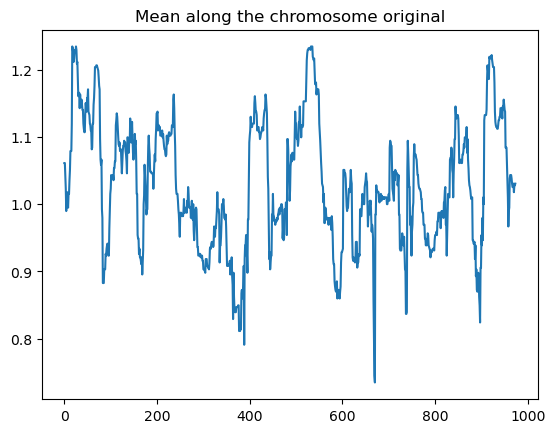

In [43]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].mean(axis = 0))), pop_1_genos[genmap["Marker"]].mean(axis = 0))
plt.title("Mean along the chromosome original")

Text(0.5, 1.0, 'Variance along the chromosome original')

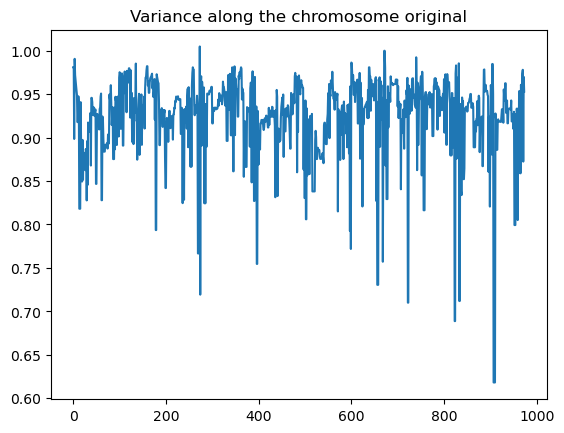

In [44]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].var(axis = 0))), pop_1_genos[genmap["Marker"]].var(axis = 0))
plt.title("Variance along the chromosome original")

In [ ]:
#set up and simulation for 1 chromosome
#requires: genomic map, parent genotypes
#builds: arbitrary pedigree, founder nodes
#simulates: ARG based on pedigree and genomic map, offspring genotypes of pedigree based on ARG and parent genotypes

#simulate genotypes of one population combination (e.g. pop 1 (B73×B97)S5)
#sim ancestry with pedigree similar to pop (~150 offspring + 5 selfing genos)

#load genmap chr1 or load entire genmap and use chr column to reduce -> in full script loop over chr and concat geno_sims
genmap = pd.read_csv("data/test_data/B73_genmap_chr1.csv")
chr1_rate_map = get_rate_map(genmap)

#set up pedigree
pop_1_ped_df = cross_selfing_ped(selfing_genos = 5)
pop_1_ped = df_to_ts(pop_1_ped_df, seq_len=297570924)
#load snp positions not strictly required since all information in genetic map 
#SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")

#reduce SNPs to chr1 of genetic map
#chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]

#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")

#choose which parents to cross
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

#simulate chromosome 1
chr1_arg = msprime.sim_ancestry(initial_state = pop_1_ped, model="fixed_pedigree", recombination_rate = chr1_rate_map)

#propagate ARG recombinations to offspring genotypes
geno_sim = propagate_geno(chr1_arg, founder_nodes, genmap)

#join haploid offspring simulation nodes to diploid individuals
genotypes = join_nodes(chr1_arg, geno_sim)

#read reference allele
ref_allele = pd.read_csv("data/test_data/B73_alleles.csv")

#reduce ref_alleles to alleles in genmap
ref_allele = ref_allele[ref_allele["SNP"].isin(genmap["Marker"])]

#recode genotype values into additive encoding
geno_add = additive_encoding(ref_allele, genotypes)

In [ ]:
#results
#draw_pedigree(pop_1_ped.tree_sequence())
#print(chr1_arg.dump_tables())
#geno_sim
#genotypes
#geno_add

In [ ]:
#TODO:
#calculate allele frequencies of real and sim pop and compare across genome -> uniform differences?
#bin loci and compare mean, var diffs between real and sim pop -> uniform diff
#-> accuracy of genetic map?

In [29]:
#calculate rogers and neis distance between real pop and simulated pop
#calculate allele frequencies
def calc_allele_freq(matrix, alleles = 3):
    num_individuals = len(matrix)
    num_snps = len(matrix[0])
    num_alleles = alleles
    allele_frequencies = []

    for j in range(num_snps):
        allele_counts = [0] * num_alleles

        for i in range(num_individuals):
            allele_counts[matrix[i][j]] += 1

        snp_frequencies = [count / num_individuals for count in allele_counts]
        allele_frequencies.extend(snp_frequencies)

    return allele_frequencies

#rogers distance

#neis distance
def neis_distance(X):
    #matrix product of X and its transpose
    d = np.matmul(X, X.T)
    
    #sqrt of diagonal elements
    vec = np.sqrt(np.diag(d))
    
    #Normalize columns of d
    d /= vec[:, np.newaxis]
    
    #Normalize rows of d
    d /= vec
    
    #negative logarithm
    d = -np.log(d)
    
    #todistance matrix
    d = np.asarray(d)
    
    return d

In [4]:
pop_1_genos_list = pop_1_genos.values.astype(int).tolist()
pop_1_genos_allele_freq = calc_allele_freq(pop_1_genos_list)
#pop_1_genos_allele_freq

NameError: name 'pop_1_genos' is not defined

In [24]:
#examples for neis distance and allele frequency functions
X = np.array([[1.0, 3.0, 5.0], [2.0, 4.0, 6.0]])

In [25]:
X

array([[1., 3., 5.],
       [2., 4., 6.]])

In [25]:
neis_distance(X)

array([[-0.        ,  0.00616024],
       [ 0.00616024, -0.        ]])

In [50]:
#example (max distance of pop with 4 individauls vs 3 individuals)
matrix_1 = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]
matrix_2 = [
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [0, 1, 1, 1]
]

freq_1 = calculate_allele_frequency(matrix_1)
freq_2 = calculate_allele_frequency(matrix_2)
print(freq_2)

[0.3333333333333333, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


In [51]:
X = np.array(list([freq_1, freq_2]))

In [52]:
neis_distance(X)

array([[-0.        ,  2.42601513],
       [ 2.42601513, -0.        ]])